# F1 Picks 2026 - Strategy Analysis

Implementing the optimal pick strategy from REPORT.md using FastF1 data.

## 2026 Regulation Changes Note
Major car/rules overhaul means historical data is less predictive than usual.
- **Early season**: Historical averages are baseline, but expect volatility
- **Form momentum becomes critical**: Recent 2026 performance matters more than ever
- **Team hierarchy may shuffle**: Don't assume 2025 pecking order holds

---
## Phase 1: Base Setup

In [1]:
# Cell 1.1: Setup and imports
import fastf1
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Enable FastF1 cache
fastf1.Cache.enable_cache('.fastf1_cache')

print("FastF1 version:", fastf1.__version__)

FastF1 version: 3.7.0


In [2]:
# Cell 1.2: Load 2026 season schedule
schedule_2026 = fastf1.get_event_schedule(2026)
# Filter to actual race events (not testing)
races_2026 = schedule_2026[schedule_2026['EventFormat'].notna()]
print(f"2026 Season: {len(races_2026)} events")
races_2026[['RoundNumber', 'EventName', 'Country', 'Location']]

2026 Season: 26 events


,RoundNumber,EventName,Country,Location
0,0,Pre-Season Testing,Bahrain,Bahrain
1,0,Pre-Season Testing,Bahrain,Bahrain
2,1,Australian Grand Prix,Australia,Melbourne
3,2,Chinese Grand Prix,China,Shanghai
4,3,Japanese Grand Prix,Japan,Suzuka
5,4,Bahrain Grand Prix,Bahrain,Sakhir
6,5,Saudi Arabian Grand Prix,Saudi Arabia,Jeddah
7,6,Miami Grand Prix,United States,Miami Gardens
8,7,Canadian Grand Prix,Canada,Montréal
9,8,Monaco Grand Prix,Monaco,Monte Carlo


In [3]:
# Cell 1.3: Load a single race result to verify data access
test_session = fastf1.get_session(2025, 1, 'R')  # Bahrain 2025
test_session.load()
test_results = test_session.results[['Abbreviation', 'Position', 'Points', 'TeamName']].copy()
print(f"Test: {test_session.event['EventName']} {test_session.event.year}")
test_results

core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


core        WARNING 	Fixed incorrect tyre stint information for driver '87'


core        WARNING 	Fixed incorrect tyre stint information for driver '30'


core        WARNING 	Fixed incorrect tyre stint information for driver '5'


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.


core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']


Test: Australian Grand Prix 2025


,Abbreviation,Position,Points,TeamName
4,NOR,1.0,25.0,McLaren
1,VER,2.0,18.0,Red Bull Racing
63,RUS,3.0,15.0,Mercedes
12,ANT,4.0,12.0,Mercedes
23,ALB,5.0,10.0,Williams
18,STR,6.0,8.0,Aston Martin
27,HUL,7.0,6.0,Kick Sauber
16,LEC,8.0,4.0,Ferrari
81,PIA,9.0,2.0,McLaren
44,HAM,10.0,1.0,Ferrari


---
## Phase 2: Expected Points Matrix

Build a driver × track matrix with expected points based on historical performance.

In [4]:
# Cell 2.1: Fetch historical race results (2024-2025, and available 2026)
# This takes a while on first run - data gets cached

def load_season_results(year: int) -> list[dict]:
    """Load all race results for a season."""
    results = []
    schedule = fastf1.get_event_schedule(year)
    # Filter to conventional/sprint_shootout format races
    races = schedule[schedule['EventFormat'].isin(['conventional', 'sprint_shootout'])]
    
    for _, event in races.iterrows():
        round_num = event['RoundNumber']
        try:
            session = fastf1.get_session(year, round_num, 'R')
            session.load()
            
            for _, row in session.results.iterrows():
                results.append({
                    'year': year,
                    'round': round_num,
                    'circuit': event['Location'],
                    'event_name': event['EventName'],
                    'driver': row['Abbreviation'],
                    'team': row['TeamName'],
                    'position': row['Position'],
                    'points': row['Points'],
                    'status': row['Status']
                })
            print(f"  Loaded: {year} Round {round_num} - {event['EventName']}")
        except Exception as e:
            print(f"  Skipped: {year} Round {round_num} - {e}")
    
    return results

# Load data for available seasons
print("Loading 2025 data...")
results_2025 = load_season_results(2025)

print("\nLoading 2024 data...")
results_2024 = load_season_results(2024)

# Try 2026 (may be partial or empty early in season)
print("\nLoading 2026 data (may be partial)...")
try:
    results_2026 = load_season_results(2026)
except:
    results_2026 = []
    print("  2026 data not yet available")

# Combine all results
all_results = results_2024 + results_2025 + results_2026
df_results = pd.DataFrame(all_results)
print(f"\nTotal results loaded: {len(df_results)}")

core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


Loading 2025 data...


core        WARNING 	Fixed incorrect tyre stint information for driver '87'


core        WARNING 	Fixed incorrect tyre stint information for driver '30'


core        WARNING 	Fixed incorrect tyre stint information for driver '5'


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.


core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']


core           INFO 	Loading data for Japanese Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 1 - Australian Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '12', '44', '6', '23', '87', '14', '22', '10', '55', '7', '27', '30', '31', '5', '18']


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 3 - Japanese Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '16', '44', '1', '10', '31', '22', '87', '12', '23', '6', '7', '14', '30', '18', '5', '55', '27']


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 4 - Bahrain Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']


core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 5 - Saudi Arabian Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '44', '23', '16', '63', '55', '6', '22', '14', '27', '10', '30', '18', '43', '87', '5', '12', '31']


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 7 - Emilia Romagna Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['4', '16', '81', '1', '44', '6', '31', '30', '23', '55', '63', '87', '43', '5', '18', '27', '22', '12', '14', '10']


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 8 - Monaco Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 19 drivers: ['81', '4', '16', '63', '27', '44', '6', '10', '14', '1', '30', '5', '22', '55', '43', '31', '87', '12', '23']


core           INFO 	Loading data for Canadian Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 9 - Spanish Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['63', '1', '12', '81', '16', '44', '14', '27', '31', '55', '87', '22', '43', '5', '10', '6', '18', '4', '30', '23']


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 10 - Canadian Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['4', '81', '16', '44', '63', '30', '14', '5', '27', '31', '87', '6', '10', '18', '43', '22', '23', '1', '12', '55']


core           INFO 	Loading data for British Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 11 - Austrian Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['4', '81', '27', '44', '1', '10', '18', '23', '14', '63', '87', '55', '31', '16', '22', '12', '6', '5', '30', '43']


core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 12 - British Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['4', '81', '63', '16', '14', '5', '18', '30', '1', '12', '6', '44', '27', '55', '23', '31', '22', '43', '10', '87']


core           INFO 	Loading data for Dutch Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 14 - Hungarian Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['81', '1', '6', '63', '23', '87', '18', '14', '22', '31', '43', '30', '55', '27', '5', '12', '10', '4', '16', '44']


core           INFO 	Loading data for Italian Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 15 - Dutch Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '44', '23', '5', '12', '6', '55', '87', '22', '30', '31', '10', '43', '18', '14', '27']


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 16 - Italian Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.


core           INFO 	Finished loading data for 20 drivers: ['1', '63', '55', '12', '30', '22', '4', '44', '16', '6', '5', '87', '23', '31', '14', '27', '18', '10', '43', '81']


core           INFO 	Loading data for Singapore Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 17 - Azerbaijan Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['63', '1', '4', '81', '12', '16', '14', '44', '87', '55', '6', '22', '18', '23', '30', '43', '5', '31', '10', '27']


core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 18 - Singapore Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['4', '16', '1', '87', '81', '12', '63', '44', '31', '5', '22', '23', '6', '18', '10', '43', '55', '14', '27', '30']


core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


core        WARNING 	Fixed incorrect tyre stint information for driver '63'


  Loaded: 2025 Round 20 - Mexico City Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['1', '63', '12', '16', '55', '6', '27', '44', '31', '87', '14', '22', '10', '30', '43', '23', '5', '18', '4', '81']


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 22 - Las Vegas Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['1', '81', '4', '16', '63', '14', '31', '44', '27', '18', '5', '87', '55', '22', '12', '23', '6', '30', '10', '43']


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2025 Round 24 - Abu Dhabi Grand Prix

Loading 2024 data...


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 1 - Bahrain Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']


core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 2 - Saudi Arabian Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']


core           INFO 	Loading data for Japanese Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 3 - Australian Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']


core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 4 - Japanese Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '81', '55', '44', '63', '11', '18', '22', '27', '20', '3', '31', '24', '10', '2', '77', '14', '23']


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 7 - Emilia Romagna Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']


core           INFO 	Loading data for Canadian Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 8 - Monaco Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['1', '4', '63', '44', '81', '14', '18', '3', '10', '31', '27', '20', '77', '22', '24', '55', '23', '11', '16', '2']


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 9 - Canadian Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.


core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '63', '16', '55', '81', '11', '10', '31', '27', '14', '24', '18', '3', '77', '20', '23', '22', '2']


core           INFO 	Loading data for British Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 10 - Spanish Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']


core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 12 - British Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']


core           INFO 	Loading data for Belgian Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


core        WARNING 	Fixed incorrect tyre stint information for driver '14'


core        WARNING 	Fixed incorrect tyre stint information for driver '3'


core        WARNING 	Fixed incorrect tyre stint information for driver '18'


core        WARNING 	Fixed incorrect tyre stint information for driver '22'


  Loaded: 2024 Round 13 - Hungarian Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['44', '81', '16', '1', '4', '55', '11', '14', '31', '3', '18', '23', '10', '20', '77', '22', '2', '27', '24', '63']


core           INFO 	Loading data for Dutch Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 14 - Belgian Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']


core           INFO 	Loading data for Italian Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 15 - Dutch Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 16 - Italian Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']


core           INFO 	Loading data for Singapore Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 17 - Azerbaijan Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['4', '1', '81', '63', '16', '44', '55', '14', '27', '11', '43', '22', '31', '18', '24', '77', '10', '3', '20', '23']


core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 18 - Singapore Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']


core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 20 - Mexico City Grand Prix


core        WARNING 	Driver 63: Lap timing integrity check failed for 2 lap(s)


core        WARNING 	Driver 44: Lap timing integrity check failed for 1 lap(s)


core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)


core        WARNING 	Driver 16: Lap timing integrity check failed for 2 lap(s)


core        WARNING 	Driver  1: Lap timing integrity check failed for 1 lap(s)


core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)


core        WARNING 	Driver 81: Lap timing integrity check failed for 1 lap(s)


core        WARNING 	Driver 30: Lap timing integrity check failed for 2 lap(s)


core        WARNING 	Driver 77: Lap timing integrity check failed for 2 lap(s)


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core        WARNING 	Driver 63 completed the race distance 00:00.427000 before the recorded end of the session.


core           INFO 	Finished loading data for 20 drivers: ['63', '44', '55', '16', '1', '4', '81', '27', '22', '11', '14', '20', '24', '43', '18', '30', '31', '77', '23', '10']


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.7.0]


req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data


req            INFO 	Using cached data for lap_count


req            INFO 	Using cached data for track_status_data


req            INFO 	Using cached data for _extended_timing_data


req            INFO 	Using cached data for timing_app_data


core           INFO 	Processing timing data...


  Loaded: 2024 Round 22 - Las Vegas Grand Prix


req            INFO 	Using cached data for car_data


req            INFO 	Using cached data for position_data


req            INFO 	Using cached data for weather_data


req            INFO 	Using cached data for race_control_messages


core           INFO 	Finished loading data for 20 drivers: ['4', '55', '16', '44', '63', '1', '10', '27', '14', '81', '23', '22', '24', '18', '61', '20', '30', '77', '43', '11']


core           INFO 	Loading data for Australian Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2024 Round 24 - Abu Dhabi Grand Prix

Loading 2026 data (may be partial)...


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Japanese Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 1 - Australian Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 3 - Japanese Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 4 - Bahrain Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 5 - Saudi Arabian Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Barcelona Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 8 - Monaco Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


  Loaded: 2026 Round 9 - Barcelona Grand Prix


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Belgian Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 10 - Austrian Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 12 - Belgian Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Italian Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 13 - Hungarian Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 15 - Italian Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 16 - Spanish Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for United States Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 17 - Azerbaijan Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 19 - United States Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 20 - Mexico City Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 21 - São Paulo Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Qatar Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 22 - Las Vegas Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.7.0]


req            INFO 	No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


  Loaded: 2026 Round 23 - Qatar Grand Prix


logger      WARNING 	Failed to load session info data!


req            INFO 	No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


core        WARNING 	Failed to load extended driver information!


core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


core        WARNING 	Failed to load driver list and session results!


req            INFO 	No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


logger      WARNING 	Failed to load session status data!


req            INFO 	No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


logger      WARNING 	Failed to load total lap count!


req            INFO 	No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


logger      WARNING 	Failed to load track status data!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


logger      WARNING 	Failed to load timing data!


core        WARNING 	Cannot load lap times for first lap from Ergast. Timing data is not available for this session.


req            INFO 	No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


core        WARNING 	Car telemetry data is unavailable!


req            INFO 	No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


core        WARNING 	Car position data is unavailable!


core        WARNING 	Failed to determine `Session.t0_date`!


req            INFO 	No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


logger      WARNING 	Failed to load weather data!


req            INFO 	No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


logger      WARNING 	Failed to load race control messages!


core           INFO 	Finished loading data for 0 drivers: []


  Loaded: 2026 Round 24 - Abu Dhabi Grand Prix

Total results loaded: 718


In [5]:
# Cell 2.2: Get 2026 driver lineup from OpenF1 API + confirmed changes
import urllib.request
import json

def fetch_openf1_drivers():
    """Fetch latest driver data from OpenF1 API."""
    url = 'https://api.openf1.org/v1/drivers?session_key=latest'
    response = urllib.request.urlopen(url)
    return json.loads(response.read().decode('utf-8'))

# Fetch current data
print("Fetching driver data from OpenF1 API...")
openf1_drivers = fetch_openf1_drivers()
print(f"Got {len(openf1_drivers)} drivers from latest session\n")

# 2026 F1 driver lineup - CONFIRMED GRID
# Based on official announcements (11 teams, 22 drivers)
# Key changes from 2025:
#   - TSU -> Red Bull test driver (out of race seat)
#   - HAD -> Red Bull Racing (promoted from Racing Bulls)
#   - LIN (Lindblad) -> Racing Bulls (rookie)
#   - DOO -> Out (replaced by Colapinto at Alpine)
#   - Cadillac joins as 11th team with PER + BOT
#   - Sauber rebranded as Audi

DRIVERS_2026 = {
    # Red Bull Racing
    'VER': ('Max Verstappen', 'Red Bull Racing'),
    'HAD': ('Isack Hadjar', 'Red Bull Racing'),  # Promoted from RB
    # Ferrari
    'LEC': ('Charles Leclerc', 'Ferrari'),
    'HAM': ('Lewis Hamilton', 'Ferrari'),
    # McLaren
    'NOR': ('Lando Norris', 'McLaren'),
    'PIA': ('Oscar Piastri', 'McLaren'),
    # Mercedes
    'RUS': ('George Russell', 'Mercedes'),
    'ANT': ('Kimi Antonelli', 'Mercedes'),
    # Aston Martin
    'ALO': ('Fernando Alonso', 'Aston Martin'),
    'STR': ('Lance Stroll', 'Aston Martin'),
    # Alpine
    'GAS': ('Pierre Gasly', 'Alpine'),
    'COL': ('Franco Colapinto', 'Alpine'),
    # Racing Bulls
    'LAW': ('Liam Lawson', 'Racing Bulls'),
    'LIN': ('Arvid Lindblad', 'Racing Bulls'),  # Rookie
    # Williams
    'ALB': ('Alexander Albon', 'Williams'),
    'SAI': ('Carlos Sainz', 'Williams'),
    # Audi (formerly Sauber)
    'HUL': ('Nico Hulkenberg', 'Audi'),
    'BOR': ('Gabriel Bortoleto', 'Audi'),
    # Haas
    'OCO': ('Esteban Ocon', 'Haas'),
    'BEA': ('Oliver Bearman', 'Haas'),
    # Cadillac (NEW TEAM)
    'PER': ('Sergio Perez', 'Cadillac'),
    'BOT': ('Valtteri Bottas', 'Cadillac'),
}

# Driver mappings for historical data (handle team/driver changes)
DRIVER_ALIASES = {
    'HAD': ['HAD'],  # Was at Racing Bulls in 2025
    'LIN': ['LIN'],  # Rookie - no F1 data
    'COL': ['COL'],  # Was at Williams/Alpine in 2025
    'PER': ['PER'],  # Was at Red Bull
    'BOT': ['BOT'],  # Was at Sauber in 2024
    'ANT': ['ANT'],  # 2025 rookie
    'BOR': ['BOR'],  # 2025 rookie
    'BEA': ['BEA'],  # 2025 (+ 2024 sub races)
}

print(f"2026 grid: {len(DRIVERS_2026)} drivers across 11 teams\n")
print(f"{'ABBR':<5} {'DRIVER':<22} {'TEAM'}")
print("-" * 50)
for abbr, (name, team) in sorted(DRIVERS_2026.items(), key=lambda x: x[1][1]):
    print(f"{abbr:<5} {name:<22} {team}")

Fetching driver data from OpenF1 API...
Got 20 drivers from latest session

2026 grid: 22 drivers across 11 teams

ABBR  DRIVER                 TEAM
--------------------------------------------------
GAS   Pierre Gasly           Alpine
COL   Franco Colapinto       Alpine
ALO   Fernando Alonso        Aston Martin
STR   Lance Stroll           Aston Martin
HUL   Nico Hulkenberg        Audi
BOR   Gabriel Bortoleto      Audi
PER   Sergio Perez           Cadillac
BOT   Valtteri Bottas        Cadillac
LEC   Charles Leclerc        Ferrari
HAM   Lewis Hamilton         Ferrari
OCO   Esteban Ocon           Haas
BEA   Oliver Bearman         Haas
NOR   Lando Norris           McLaren
PIA   Oscar Piastri          McLaren
RUS   George Russell         Mercedes
ANT   Kimi Antonelli         Mercedes
LAW   Liam Lawson            Racing Bulls
LIN   Arvid Lindblad         Racing Bulls
VER   Max Verstappen         Red Bull Racing
HAD   Isack Hadjar           Red Bull Racing
ALB   Alexander Albon        Willi

In [6]:
# Cell 2.3: Build driver × circuit expected points matrix

def get_driver_circuit_matrix(df: pd.DataFrame, drivers: dict) -> pd.DataFrame:
    """Build expected points matrix for drivers at each circuit."""
    
    # Get unique circuits
    circuits = df['circuit'].unique()
    
    # Initialize matrix
    matrix = pd.DataFrame(index=drivers.keys(), columns=circuits, dtype=float)
    matrix[:] = np.nan
    
    # Calculate average points per driver per circuit
    for driver_abbr in drivers.keys():
        # Get aliases for this driver
        aliases = DRIVER_ALIASES.get(driver_abbr, [driver_abbr])
        
        # Filter data for this driver (or aliases)
        driver_data = df[df['driver'].isin(aliases)]
        
        for circuit in circuits:
            circuit_data = driver_data[driver_data['circuit'] == circuit]
            if len(circuit_data) > 0:
                # Weight more recent years higher (2026 > 2025 > 2024)
                weights = circuit_data['year'].apply(lambda y: 1.0 if y == 2026 else (0.8 if y == 2025 else 0.5))
                matrix.loc[driver_abbr, circuit] = np.average(circuit_data['points'], weights=weights)
    
    return matrix

# Build the matrix
expected_points = get_driver_circuit_matrix(df_results, DRIVERS_2026)

# Show summary
print(f"Matrix shape: {expected_points.shape}")
print(f"\nDrivers with data: {expected_points.notna().any(axis=1).sum()}")
print(f"Circuits: {len(expected_points.columns)}")

Matrix shape: (22, 19)

Drivers with data: 21
Circuits: 19


In [7]:
# Cell 2.4: Fill missing data with team/tier estimates

# Team tier estimates for 2026 (adjust based on 2025 standings + new regs predictions)
# Note: 2026 has major regulation changes - these are rough estimates
TEAM_BASELINE_POINTS = {
    'Red Bull Racing': 14.0,
    'Ferrari': 14.0,
    'McLaren': 15.0,  # 2025 champions
    'Mercedes': 10.0,
    'Aston Martin': 6.0,  # Newey effect?
    'Alpine': 3.0,
    'Racing Bulls': 3.0,
    'Williams': 3.0,
    'Audi': 1.0,  # Formerly Sauber, new works team ramp-up
    'Haas': 2.5,
    'Cadillac': 0.5,  # Brand new team
}

def fill_missing_with_team_baseline(matrix: pd.DataFrame, drivers: dict) -> pd.DataFrame:
    """Fill missing values with team baseline estimates."""
    filled = matrix.copy()
    
    for driver_abbr, (name, team) in drivers.items():
        baseline = TEAM_BASELINE_POINTS.get(team, 2.0)
        # Rookies get a penalty, sophomores less so
        if driver_abbr == 'LIN':  # True rookie
            baseline *= 0.6
        elif driver_abbr in ['ANT', 'BOR', 'BEA', 'HAD', 'COL']:  # Sophomores
            baseline *= 0.85
        filled.loc[driver_abbr] = filled.loc[driver_abbr].fillna(baseline)
    
    return filled

expected_points_filled = fill_missing_with_team_baseline(expected_points, DRIVERS_2026)

# Show the matrix
print("Expected Points Matrix (sample columns):")
expected_points_filled.iloc[:, :5].round(1)

Expected Points Matrix (sample columns):


,Sakhir,Jeddah,Melbourne,Suzuka,Imola
VER,14.9,20.7,11.1,25.4,25.0
HAD,0.0,1.0,0.0,4.0,2.0
LEC,12.0,15.4,9.8,12.0,10.7
HAM,8.5,4.5,0.6,4.5,10.5
NOR,12.3,8.9,21.2,14.9,18.0
PIA,16.9,20.0,5.8,10.8,13.8
RUS,14.9,9.2,9.2,8.5,6.4
ANT,0.0,8.0,12.0,8.0,0.0
ALO,0.8,3.8,1.5,3.1,0.0
STR,0.4,0.0,8.0,0.0,0.8


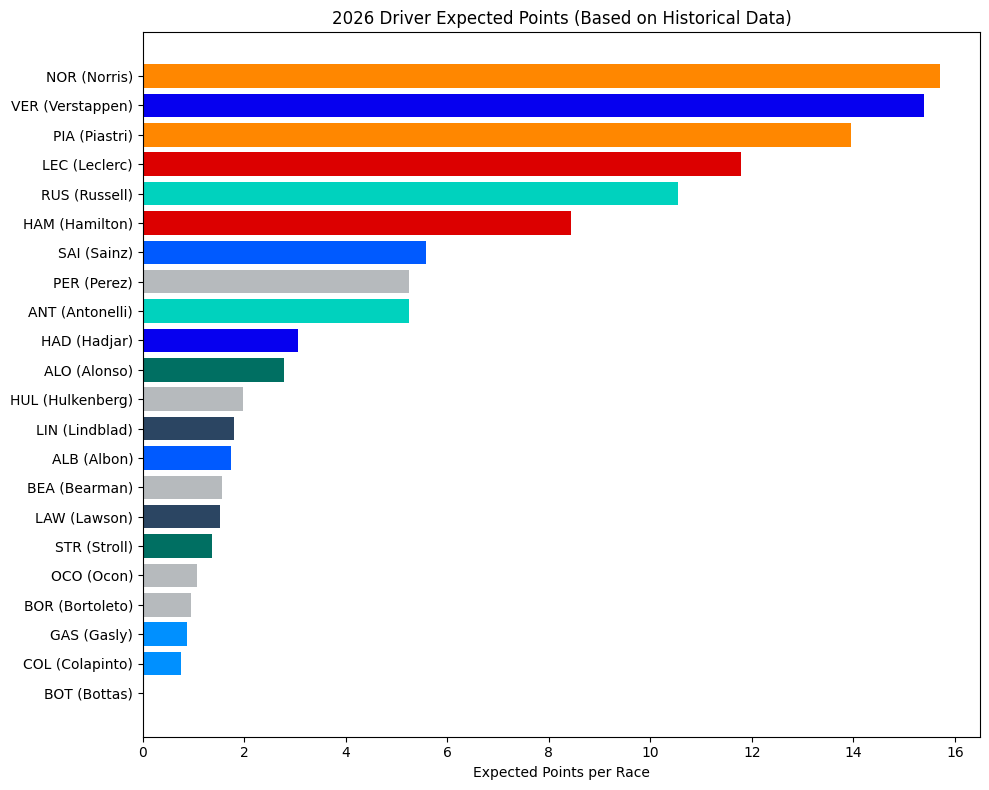


Season average expected points:


NOR    15.71
VER    15.38
PIA    13.96
LEC    11.78
RUS    10.54
HAM     8.44
SAI     5.57
PER     5.24
ANT     5.24
HAD     3.05
ALO     2.79
HUL     1.96
LIN     1.80
ALB     1.73
BEA     1.57
LAW     1.53
STR     1.36
OCO     1.06
BOR     0.94
GAS     0.87
COL     0.75
BOT     0.03
dtype: float64

In [8]:
# Cell 2.5: Visualize driver expected points (season average)

season_avg = expected_points_filled.mean(axis=1).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
colors = ['#0600EF' if 'Red Bull' in DRIVERS_2026[d][1] else
          '#DC0000' if 'Ferrari' in DRIVERS_2026[d][1] else
          '#FF8700' if 'McLaren' in DRIVERS_2026[d][1] else
          '#00D2BE' if 'Mercedes' in DRIVERS_2026[d][1] else
          '#006F62' if 'Aston' in DRIVERS_2026[d][1] else
          '#0090FF' if 'Alpine' in DRIVERS_2026[d][1] else
          '#2B4562' if 'Racing Bulls' in DRIVERS_2026[d][1] else
          '#005AFF' if 'Williams' in DRIVERS_2026[d][1] else
          '#52E252' if 'Sauber' in DRIVERS_2026[d][1] else
          '#B6BABD' for d in season_avg.index]

plt.barh(range(len(season_avg)), season_avg.values, color=colors)
plt.yticks(range(len(season_avg)), [f"{d} ({DRIVERS_2026[d][0].split()[-1]})" for d in season_avg.index])
plt.xlabel('Expected Points per Race')
plt.title('2026 Driver Expected Points (Based on Historical Data)')
plt.tight_layout()
plt.show()

print("\nSeason average expected points:")
season_avg.sort_values(ascending=False).round(2)

---
## Phase 3: Optimal Allocation (Hungarian Algorithm)

Solve the assignment problem: assign each driver to exactly one race to maximize total expected points.

In [ ]:
# Cell 3.0: YOUR ACTUAL PICKS & RESULTS (edit as the season progresses)
# 
# MY_PICKS: Enter the driver you picked for each completed race
# ACTUAL_POINTS: Enter the points your pick actually scored that weekend
#
# Format: round_number: 'DRIVER_ABBR' or round_number: points

MY_PICKS = {
    # Example mid-season:
    # 1: 'VER',   # Australian GP - picked Verstappen
    # 2: 'LEC',   # Chinese GP - picked Leclerc  
    # 3: 'NOR',   # Japanese GP - picked Norris
}

ACTUAL_POINTS = {
    # Enter the total points your pick scored (race + sprint if applicable)
    # Example:
    # 1: 25,  # Verstappen won the race
    # 2: 21,  # Leclerc: 3rd race (15) + 2nd sprint (7) - not real, just example
    # 3: 18,  # Norris P2
}

# Validate picks
used_drivers = set(MY_PICKS.values())
completed_rounds = set(MY_PICKS.keys())

# Validate driver abbreviations
invalid_drivers = used_drivers - set(DRIVERS_2026.keys())
if invalid_drivers:
    raise ValueError(f"Invalid driver abbreviations in MY_PICKS: {invalid_drivers}")

# Validate round numbers
invalid_rounds = {r for r in completed_rounds if r < 1 or r > 24}
if invalid_rounds:
    raise ValueError(f"Invalid round numbers in MY_PICKS (must be 1-24): {invalid_rounds}")

# Validate ACTUAL_POINTS matches MY_PICKS
mismatched_rounds = set(ACTUAL_POINTS.keys()) - completed_rounds
if mismatched_rounds:
    print(f"⚠️  Warning: ACTUAL_POINTS has rounds not in MY_PICKS: {mismatched_rounds}")

print(f"SEASON PROGRESS: {len(MY_PICKS)}/24 races picked")
print(f"Drivers used: {', '.join(sorted(used_drivers)) if used_drivers else 'None'}")
print(f"Drivers available: {len(DRIVERS_2026) - len(used_drivers)} remaining")

# Score tracker: compare predicted vs actual
if ACTUAL_POINTS:
    print("\n" + "=" * 50)
    print("SCORE TRACKER")
    print("=" * 50)
    
    total_actual = sum(ACTUAL_POINTS.values())
    
    # Calculate what was predicted for those picks
    total_predicted = 0
    for rnd, driver in MY_PICKS.items():
        if rnd in ACTUAL_POINTS:
            race_info = next((r for r in race_calendar if r['round'] == rnd), None) if 'race_calendar' in dir() else None
            circuit = race_info['circuit'] if race_info else None
            
            # Get expected points (will be available after expected_points_filled is created)
            if 'expected_points_filled' in dir() and circuit and circuit in expected_points_filled.columns:
                exp = expected_points_filled.loc[driver, circuit]
                if race_info and race_info.get('is_sprint'):
                    exp *= 1.30  # Sprint bonus
            else:
                exp = 0
            total_predicted += exp
    
    print(f"\n{'Round':<6} {'Driver':<6} {'Predicted':>10} {'Actual':>10} {'Diff':>10}")
    print("-" * 50)
    
    for rnd in sorted(ACTUAL_POINTS.keys()):
        driver = MY_PICKS.get(rnd, '???')
        actual = ACTUAL_POINTS[rnd]
        
        # Get predicted (simplified - will refine after matrices built)
        race_info = next((r for r in race_calendar if r['round'] == rnd), None) if 'race_calendar' in dir() else None
        if 'expected_points_filled' in dir() and race_info:
            circuit = race_info['circuit']
            if circuit in expected_points_filled.columns:
                pred = expected_points_filled.loc[driver, circuit]
                if race_info.get('is_sprint'):
                    pred *= 1.30
            else:
                pred = 0
        else:
            pred = 0
        
        diff = actual - pred
        diff_str = f"+{diff:.1f}" if diff >= 0 else f"{diff:.1f}"
        print(f"R{rnd:<5} {driver:<6} {pred:>10.1f} {actual:>10.0f} {diff_str:>10}")
    
    print("-" * 50)
    print(f"{'TOTAL':<13} {total_predicted:>10.1f} {total_actual:>10.0f}")
    
    if total_actual > total_predicted:
        print(f"\n✅ AHEAD of predictions by {total_actual - total_predicted:.1f} points!")
    elif total_actual < total_predicted:
        print(f"\n⚠️  BEHIND predictions by {total_predicted - total_actual:.1f} points")
    else:
        print(f"\n➡️  Exactly on track with predictions")

In [10]:
# Cell 3.1: Get 2026 race calendar from OpenF1 API

def fetch_openf1_meetings(year: int) -> list:
    """Fetch race calendar from OpenF1 API."""
    url = f'https://api.openf1.org/v1/meetings?year={year}'
    response = urllib.request.urlopen(url)
    meetings = json.loads(response.read().decode('utf-8'))
    return [m for m in meetings if 'Grand Prix' in m.get('meeting_name', '')]

print("Fetching 2026 calendar from OpenF1 API...")
meetings_2026 = fetch_openf1_meetings(2026)
meetings_2026.sort(key=lambda x: x.get('date_start', ''))

# Sprint weekends for 2026 (from README rules)
SPRINT_WEEKENDS = {'Chinese', 'Miami', 'Canadian', 'British', 'Dutch', 'Singapore'}

# Create race calendar
race_calendar = []
for i, m in enumerate(meetings_2026, 1):
    name = m.get('meeting_name', '')
    is_sprint = any(s in name for s in SPRINT_WEEKENDS)
    is_wildcard = i >= 23  # Last 2 races are wild cards
    
    race_calendar.append({
        'round': i,
        'meeting_key': m.get('meeting_key'),
        'name': name,
        'circuit': m.get('location'),
        'country': m.get('country_name', ''),
        'date': m.get('date_start', '')[:10],
        'is_sprint': is_sprint,
        'is_wildcard': is_wildcard,
    })

print(f"\n2026 CALENDAR: {len(race_calendar)} races")
print(f"  - Rounds 1-22: Use each driver exactly once")
print(f"  - Rounds 23-24: WILD CARDS (pick anyone)")
print(f"  - Sprint weekends: {len([r for r in race_calendar if r['is_sprint']])} races")
print()
print("=" * 80)
print(f"{'R#':<3} {'DATE':<12} {'GRAND PRIX':<32} {'CIRCUIT':<18} {'TYPE'}")
print("-" * 80)
for r in race_calendar:
    race_type = []
    if r['is_sprint']:
        race_type.append('SPRINT')
    if r['is_wildcard']:
        race_type.append('WILD')
    type_str = '+'.join(race_type) if race_type else '-'
    print(f"R{r['round']:<2} {r['date']:<12} {r['name']:<32} {r['circuit']:<18} {type_str}")

Fetching 2026 calendar from OpenF1 API...



2026 CALENDAR: 24 races
  - Rounds 1-22: Use each driver exactly once
  - Rounds 23-24: WILD CARDS (pick anyone)
  - Sprint weekends: 6 races

R#  DATE         GRAND PRIX                       CIRCUIT            TYPE
--------------------------------------------------------------------------------
R1  2026-03-06   Australian Grand Prix            Melbourne          -
R2  2026-03-13   Chinese Grand Prix               Shanghai           SPRINT
R3  2026-03-27   Japanese Grand Prix              Suzuka             -
R4  2026-04-10   Bahrain Grand Prix               Sakhir             -
R5  2026-04-17   Saudi Arabian Grand Prix         Jeddah             -
R6  2026-05-01   Miami Grand Prix                 Miami Gardens      SPRINT
R7  2026-05-22   Canadian Grand Prix              Montréal           SPRINT
R8  2026-06-05   Monaco Grand Prix                Monte Carlo        -
R9  2026-06-12   Barcelona Grand Prix             Barcelona          -
R10 2026-06-26   Austrian Grand Prix           

In [ ]:
# Cell 3.2: Build cost matrix with sprint bonus

# Sprint bonus explanation:
# On sprint weekends, top drivers score additional points from the sprint race.
# Sprint race max: 8 points (1st place) vs Main race max: 25 points (1st place)
# Top drivers typically score ~6 extra points in sprints (positions 1-4)
# This works out to roughly 6/20 ≈ 30% bonus to expected weekend points.
#
# Validation opportunity: Compare actual 2024-2025 sprint weekend totals
# vs non-sprint weekends to refine this factor.
SPRINT_BONUS_FACTOR = 1.30

def build_cost_matrix(expected_points: pd.DataFrame, race_calendar: list,
                      used_drivers: set = None, completed_rounds: set = None) -> tuple[np.ndarray, list, list]:
    """Build cost matrix for Hungarian algorithm.
    
    Only includes remaining races (excludes completed rounds and wild cards).
    Only includes remaining drivers (excludes already-used drivers).
    Applies sprint bonus to sprint weekend races.
    
    Args:
        expected_points: DataFrame with drivers as index, circuits as columns
        race_calendar: List of race dicts with round, circuit, is_sprint, is_wildcard
        used_drivers: Set of driver abbreviations already picked (from MY_PICKS)
        completed_rounds: Set of round numbers already completed (from MY_PICKS)
    
    Returns:
        cost_matrix: Negative expected points matrix for Hungarian algorithm
        remaining_drivers: List of driver abbreviations still available
        remaining_races: List of race dicts still to be assigned
    """
    used_drivers = used_drivers or set()
    completed_rounds = completed_rounds or set()
    
    # Filter to remaining drivers
    all_drivers = list(expected_points.index)
    remaining_drivers = [d for d in all_drivers if d not in used_drivers]
    
    # Filter to remaining races (exclude wild cards and completed rounds)
    remaining_races = [r for r in race_calendar 
                       if not r['is_wildcard'] and r['round'] not in completed_rounds]
    
    n_drivers = len(remaining_drivers)
    n_races = len(remaining_races)
    
    print(f"Remaining allocation: {n_drivers} drivers × {n_races} races")
    if used_drivers:
        print(f"  (Excluded {len(used_drivers)} used drivers: {', '.join(sorted(used_drivers))})")
    if completed_rounds:
        print(f"  (Excluded {len(completed_rounds)} completed rounds)")
    print(f"(Wild card races handled separately)")
    
    # Build the points matrix for remaining drivers/races
    points_matrix = np.zeros((n_drivers, n_races))
    
    for j, race in enumerate(remaining_races):
        circuit = race['circuit']
        
        for i, driver in enumerate(remaining_drivers):
            # Get base expected points for this driver at this circuit
            if circuit in expected_points.columns:
                base_points = expected_points.loc[driver, circuit]
            else:
                # Use driver's season average for unknown circuits
                base_points = expected_points.loc[driver].mean()
            
            # Apply sprint bonus if applicable
            if race['is_sprint']:
                points_matrix[i, j] = base_points * SPRINT_BONUS_FACTOR
            else:
                points_matrix[i, j] = base_points
    
    # Negate for minimization (Hungarian solves min-cost)
    cost_matrix = -points_matrix
    
    return cost_matrix, remaining_drivers, remaining_races

cost_matrix, drivers, constrained_races = build_cost_matrix(
    expected_points_filled, race_calendar, used_drivers, completed_rounds
)
print(f"\nCost matrix shape: {cost_matrix.shape}")

In [12]:
# Cell 3.3: Solve allocation (completed picks + remaining + wild cards)

def solve_optimal_allocation(cost_matrix: np.ndarray, remaining_drivers: list, 
                             remaining_races: list, all_races: list,
                             expected_points: pd.DataFrame,
                             my_picks: dict = None) -> pd.DataFrame:
    """Solve the optimal driver-race allocation.
    
    - Completed races: User's actual picks from MY_PICKS
    - Remaining races: Hungarian algorithm (each driver used once)
    - Wild card races: Pick best available drivers
    
    Args:
        cost_matrix: Cost matrix for remaining drivers × remaining races
        remaining_drivers: List of drivers not yet used
        remaining_races: List of races not yet completed (excluding wild cards)
        all_races: Full race calendar
        expected_points: Full expected points matrix
        my_picks: Dict of {round: driver_abbr} for completed races
    
    Returns:
        DataFrame with all race allocations and status column
    """
    my_picks = my_picks or {}
    
    allocations = []
    
    # --- PART 1: Completed races (from MY_PICKS) ---
    for race in all_races:
        if race['round'] in my_picks:
            driver = my_picks[race['round']]
            circuit = race['circuit']
            
            # Get actual expected points for the pick
            if circuit in expected_points.columns:
                exp_pts = expected_points.loc[driver, circuit]
            else:
                exp_pts = expected_points.loc[driver].mean()
            
            # Apply sprint bonus if applicable
            if race['is_sprint']:
                exp_pts *= SPRINT_BONUS_FACTOR
            
            allocations.append({
                'round': race['round'],
                'race': race['name'],
                'circuit': circuit,
                'driver': driver,
                'driver_name': DRIVERS_2026[driver][0],
                'team': DRIVERS_2026[driver][1],
                'expected_points': exp_pts,
                'is_sprint': race['is_sprint'],
                'is_wildcard': False,
                'status': 'COMPLETED'
            })
    
    # --- PART 2: Remaining constrained allocation (Hungarian algorithm) ---
    n_drivers = len(remaining_drivers)
    n_races = len(remaining_races)
    
    if n_drivers > 0 and n_races > 0:
        # Ensure square matrix for Hungarian algorithm
        assert n_drivers == n_races, f"Mismatch: {n_drivers} drivers vs {n_races} races"
        
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        for i, j in zip(row_ind, col_ind):
            driver = remaining_drivers[i]
            race = remaining_races[j]
            expected_pts = -cost_matrix[i, j]
            allocations.append({
                'round': race['round'],
                'race': race['name'],
                'circuit': race['circuit'],
                'driver': driver,
                'driver_name': DRIVERS_2026[driver][0],
                'team': DRIVERS_2026[driver][1],
                'expected_points': expected_pts,
                'is_sprint': race['is_sprint'],
                'is_wildcard': False,
                'status': 'RECOMMENDED'
            })
    
    # --- PART 3: Wild card races (R23-R24) ---
    wildcard_races = [r for r in all_races if r['is_wildcard']]
    
    for race in wildcard_races:
        circuit = race['circuit']
        
        # Get expected points for this circuit (all drivers available for wild cards)
        if circuit in expected_points.columns:
            circuit_points = expected_points[circuit]
        else:
            circuit_points = expected_points.mean(axis=1)
        
        # Pick the driver with highest expected points
        best_driver = circuit_points.idxmax()
        best_pts = circuit_points.max()
        
        # Apply sprint bonus if applicable
        if race['is_sprint']:
            best_pts *= SPRINT_BONUS_FACTOR
        
        allocations.append({
            'round': race['round'],
            'race': race['name'],
            'circuit': circuit,
            'driver': best_driver,
            'driver_name': DRIVERS_2026[best_driver][0],
            'team': DRIVERS_2026[best_driver][1],
            'expected_points': best_pts,
            'is_sprint': race['is_sprint'],
            'is_wildcard': True,
            'status': 'WILDCARD'
        })
    
    df = pd.DataFrame(allocations)
    df = df.sort_values('round').reset_index(drop=True)
    return df

optimal_allocation = solve_optimal_allocation(
    cost_matrix, drivers, constrained_races, race_calendar, 
    expected_points_filled, MY_PICKS
)

# Summary stats
completed_pts = optimal_allocation[optimal_allocation['status'] == 'COMPLETED']['expected_points'].sum()
recommended_pts = optimal_allocation[optimal_allocation['status'] == 'RECOMMENDED']['expected_points'].sum()
wildcard_pts = optimal_allocation[optimal_allocation['status'] == 'WILDCARD']['expected_points'].sum()
total_pts = optimal_allocation['expected_points'].sum()

print(f"ALLOCATION SUMMARY:")
if len(MY_PICKS) > 0:
    print(f"  Completed ({len(MY_PICKS)} races): {completed_pts:.1f} expected points")
print(f"  Recommended ({len(optimal_allocation[optimal_allocation['status'] == 'RECOMMENDED'])} races): {recommended_pts:.1f} expected points")
print(f"  Wild cards (2 races): {wildcard_pts:.1f} expected points")
print(f"  TOTAL: {total_pts:.1f} expected points")
print(f"  Average per race: {total_pts/len(optimal_allocation):.2f}")

ALLOCATION SUMMARY:
  Recommended (22 races): 274.6 expected points
  Wild cards (2 races): 31.4 expected points
  TOTAL: 306.0 expected points
  Average per race: 12.75


In [13]:
# Cell 3.4: Display optimal season plan

print("=" * 90)
print("OPTIMAL 2026 PICK ALLOCATION")
print("=" * 90)

# Show completed picks section if any
completed = optimal_allocation[optimal_allocation['status'] == 'COMPLETED']
if len(completed) > 0:
    print(f"\n{'─' * 90}")
    print("COMPLETED PICKS (Your actual selections)")
    print(f"{'─' * 90}")
    print(f"{'R#':<3} {'RACE':<28} {'DRIVER':<20} {'TEAM':<18} {'PTS':>6} {'TYPE'}")
    print("-" * 90)
    
    for _, row in completed.iterrows():
        flags = ['✓']  # Checkmark for completed
        if row['is_sprint']:
            flags.append('S')
        type_str = '+'.join(flags)
        
        driver_str = f"{row['driver']} ({row['driver_name'].split()[-1]})"
        print(f"R{row['round']:<2} {row['race']:<28} {driver_str:<20} {row['team']:<18} {row['expected_points']:>5.1f} {type_str}")
    
    print(f"\nCompleted subtotal: {completed['expected_points'].sum():.1f} expected points")

# Show recommended picks section
recommended = optimal_allocation[optimal_allocation['status'] == 'RECOMMENDED']
if len(recommended) > 0:
    print(f"\n{'─' * 90}")
    print("RECOMMENDED PICKS (Optimization for remaining races)")
    print(f"{'─' * 90}")
    print(f"{'R#':<3} {'RACE':<28} {'DRIVER':<20} {'TEAM':<18} {'PTS':>6} {'TYPE'}")
    print("-" * 90)
    
    for _, row in recommended.iterrows():
        flags = []
        if row['is_sprint']:
            flags.append('S')
        type_str = '+'.join(flags) if flags else '-'
        
        driver_str = f"{row['driver']} ({row['driver_name'].split()[-1]})"
        print(f"R{row['round']:<2} {row['race']:<28} {driver_str:<20} {row['team']:<18} {row['expected_points']:>5.1f} {type_str}")
    
    print(f"\nRecommended subtotal: {recommended['expected_points'].sum():.1f} expected points")

# Show wild card picks
wildcards = optimal_allocation[optimal_allocation['status'] == 'WILDCARD']
if len(wildcards) > 0:
    print(f"\n{'─' * 90}")
    print("WILD CARD PICKS (Can reuse any driver)")
    print(f"{'─' * 90}")
    print(f"{'R#':<3} {'RACE':<28} {'DRIVER':<20} {'TEAM':<18} {'PTS':>6} {'TYPE'}")
    print("-" * 90)
    
    for _, row in wildcards.iterrows():
        flags = ['W']
        if row['is_sprint']:
            flags.append('S')
        type_str = '+'.join(flags)
        
        driver_str = f"{row['driver']} ({row['driver_name'].split()[-1]})"
        print(f"R{row['round']:<2} {row['race']:<28} {driver_str:<20} {row['team']:<18} {row['expected_points']:>5.1f} {type_str}")
    
    print(f"\nWild card subtotal: {wildcards['expected_points'].sum():.1f} expected points")

print("=" * 90)
print(f"TOTAL EXPECTED: {optimal_allocation['expected_points'].sum():.1f} points")
print(f"Legend: ✓=Completed, S=Sprint weekend, W=Wild card")
print("=" * 90)

OPTIMAL 2026 PICK ALLOCATION

──────────────────────────────────────────────────────────────────────────────────────────
RECOMMENDED PICKS (Optimization for remaining races)
──────────────────────────────────────────────────────────────────────────────────────────
R#  RACE                         DRIVER               TEAM                  PTS TYPE
------------------------------------------------------------------------------------------
R1  Australian Grand Prix        STR (Stroll)         Aston Martin         8.0 -
R2  Chinese Grand Prix           LEC (Leclerc)        Ferrari             15.3 S
R3  Japanese Grand Prix          VER (Verstappen)     Red Bull Racing     25.4 -
R4  Bahrain Grand Prix           PER (Perez)          Cadillac            18.0 -
R5  Saudi Arabian Grand Prix     PIA (Piastri)        McLaren             20.0 -
R6  Miami Grand Prix             ALO (Alonso)         Aston Martin         3.6 S
R7  Canadian Grand Prix          ANT (Antonelli)      Mercedes           

In [14]:
# Cell 3.5: Identify close calls (races where multiple drivers are similar)

def find_close_calls(cost_matrix: np.ndarray, drivers: list, races: list, 
                     allocation: pd.DataFrame, threshold: float = 2.0) -> list:
    """Find races where alternative picks are within threshold points of optimal."""
    close_calls = []
    
    for j, race in enumerate(races):
        # Skip wild card races (not in constrained allocation)
        alloc_row = allocation[allocation['round'] == race['round']]
        if len(alloc_row) == 0 or alloc_row.iloc[0]['is_wildcard']:
            continue
            
        assigned_driver = alloc_row['driver'].values[0]
        assigned_idx = drivers.index(assigned_driver)
        assigned_pts = -cost_matrix[assigned_idx, j]
        
        alternatives = []
        for i, driver in enumerate(drivers):
            if driver != assigned_driver:
                pts = -cost_matrix[i, j]
                diff = assigned_pts - pts
                if diff < threshold:
                    alternatives.append({
                        'driver': driver,
                        'points': pts,
                        'diff': diff
                    })
        
        if alternatives:
            alternatives.sort(key=lambda x: x['diff'])
            close_calls.append({
                'round': race['round'],
                'race': race['name'],
                'assigned': assigned_driver,
                'assigned_pts': assigned_pts,
                'alternatives': alternatives[:3]  # Top 3 alternatives
            })
    
    return close_calls

close_calls = find_close_calls(cost_matrix, drivers, constrained_races, optimal_allocation, threshold=3.0)

print("\nCLOSE CALLS (alternatives within 3 pts):")
print("-" * 70)
for cc in close_calls:
    alts = ", ".join([f"{a['driver']} ({a['points']:.1f})" for a in cc['alternatives']])
    print(f"R{cc['round']:2d} {cc['race']:<25} | Picked: {cc['assigned']} ({cc['assigned_pts']:.1f})")
    print(f"    Alternatives: {alts}")


CLOSE CALLS (alternatives within 3 pts):
----------------------------------------------------------------------
R 1 Australian Grand Prix     | Picked: STR (8.0)
    Alternatives: NOR (21.2), ANT (12.0), VER (11.1)
R 2 Chinese Grand Prix        | Picked: LEC (15.3)
    Alternatives: NOR (20.4), VER (20.0), PIA (18.1)
R 4 Bahrain Grand Prix        | Picked: PER (18.0)
    Alternatives: PIA (16.9)
R 5 Saudi Arabian Grand Prix  | Picked: PIA (20.0)
    Alternatives: VER (20.7), PER (18.0)
R 6 Miami Grand Prix          | Picked: ALO (3.6)
    Alternatives: NOR (20.4), VER (20.0), PIA (18.1)
R 7 Canadian Grand Prix       | Picked: ANT (19.5)
    Alternatives: RUS (27.5), VER (26.9)
R 8 Monaco Grand Prix         | Picked: LIN (1.8)
    Alternatives: NOR (15.7), VER (15.4), PIA (14.0)
R 9 Barcelona Grand Prix      | Picked: GAS (3.2)
    Alternatives: NOR (18.4), PIA (17.7), LEC (13.1)
R11 British Grand Prix        | Picked: HUL (16.0)
    Alternatives: NOR (27.5), HAM (22.1), PIA (20.4)
R13

---
## Phase 4: Form Momentum Tracker

Track recent performance to identify hot/cold drivers for mid-season adjustments.

In [15]:
# Cell 4.1: Calculate rolling performance metrics

def calculate_driver_form(df: pd.DataFrame, window: int = 3) -> pd.DataFrame:
    """Calculate rolling average and form indicators for each driver."""
    
    form_data = []
    
    for driver in df['driver'].unique():
        driver_results = df[df['driver'] == driver].sort_values(['year', 'round'])
        
        if len(driver_results) >= window:
            # Season average
            season_avg = driver_results['points'].mean()
            
            # Rolling average (last N races)
            rolling_avg = driver_results['points'].tail(window).mean()
            
            # Form delta
            form_delta = rolling_avg - season_avg
            
            # Classify form
            if form_delta > 3:
                form_status = 'HOT'
            elif form_delta < -3:
                form_status = 'COLD'
            else:
                form_status = 'NORMAL'
            
            form_data.append({
                'driver': driver,
                'races': len(driver_results),
                'season_avg': season_avg,
                'rolling_avg': rolling_avg,
                'form_delta': form_delta,
                'form_status': form_status
            })
    
    return pd.DataFrame(form_data).sort_values('form_delta', ascending=False)

# Calculate form from most recent data
latest_year = df_results['year'].max()
recent_results = df_results[df_results['year'] == latest_year]

driver_form = calculate_driver_form(recent_results, window=3)
print(f"Form analysis (last 3 races of {latest_year}):")
driver_form[['driver', 'season_avg', 'rolling_avg', 'form_delta', 'form_status']].round(2)

Form analysis (last 3 races of 2025):


,driver,season_avg,rolling_avg,form_delta,form_status
1,VER,16.00,21.67,5.67,HOT
7,LEC,10.28,14.00,3.72,HOT
13,BEA,1.39,4.33,2.94,NORMAL
3,ANT,5.06,7.67,2.61,NORMAL
12,OCO,1.33,3.33,2.00,NORMAL
17,SAI,2.00,3.33,1.33,NORMAL
16,ALO,2.44,2.67,0.22,NORMAL
6,HUL,2.50,2.67,0.17,NORMAL
19,HAD,2.56,2.67,0.11,NORMAL
20,COL,0.00,0.00,0.00,NORMAL


In [16]:
# Cell 4.2: Form-adjusted recommendations

def get_form_adjusted_picks(allocation: pd.DataFrame, form: pd.DataFrame, 
                            threshold: float = 4.0) -> list:
    """Suggest pick swaps based on current form."""
    
    hot_drivers = set(form[form['form_status'] == 'HOT']['driver'].values)
    cold_drivers = set(form[form['form_status'] == 'COLD']['driver'].values)
    
    suggestions = []
    
    for _, pick in allocation.iterrows():
        driver = pick['driver']
        
        if driver in cold_drivers:
            # Suggest swapping out cold driver if there's a hot alternative nearby
            suggestions.append({
                'round': pick['round'],
                'race': pick['race'],
                'issue': f"{driver} is COLD",
                'recommendation': 'Consider swapping if a HOT driver is available'
            })
        elif driver in hot_drivers:
            suggestions.append({
                'round': pick['round'],
                'race': pick['race'],
                'issue': f"{driver} is HOT",
                'recommendation': 'Good pick - driver is in form'
            })
    
    return suggestions

form_suggestions = get_form_adjusted_picks(optimal_allocation, driver_form)

print("\nFORM-BASED RECOMMENDATIONS:")
print("-" * 60)
for s in form_suggestions:
    print(f"R{s['round']:2d} {s['race']:<25} | {s['issue']}")
    print(f"    -> {s['recommendation']}")


FORM-BASED RECOMMENDATIONS:
------------------------------------------------------------
R 2 Chinese Grand Prix        | LEC is HOT
    -> Good pick - driver is in form
R 3 Japanese Grand Prix       | VER is HOT
    -> Good pick - driver is in form
R 5 Saudi Arabian Grand Prix  | PIA is COLD
    -> Consider swapping if a HOT driver is available


---
## Phase 5: Consistency Analysis

Analyze driver variance to inform risk-adjusted picks.

In [17]:
# Cell 5.1: Calculate driver consistency metrics

def calculate_consistency(df: pd.DataFrame, min_races: int = 5) -> pd.DataFrame:
    """Calculate consistency metrics for each driver."""
    
    consistency_data = []
    
    for driver in df['driver'].unique():
        driver_results = df[df['driver'] == driver]
        
        if len(driver_results) >= min_races:
            points = driver_results['points']
            
            mean_pts = points.mean()
            std_pts = points.std()
            cv = std_pts / mean_pts if mean_pts > 0 else float('inf')  # Coefficient of variation
            
            # Count zeros (DNFs/no points)
            zero_pct = (points == 0).sum() / len(points) * 100
            
            # Count podiums
            podium_pct = (points >= 15).sum() / len(points) * 100
            
            # Classify
            if cv < 0.5:
                consistency_class = 'CONSISTENT'
            elif cv < 1.0:
                consistency_class = 'VARIABLE'
            else:
                consistency_class = 'BOOM-BUST'
            
            consistency_data.append({
                'driver': driver,
                'races': len(driver_results),
                'mean_pts': mean_pts,
                'std_pts': std_pts,
                'cv': cv,
                'zero_pct': zero_pct,
                'podium_pct': podium_pct,
                'consistency': consistency_class
            })
    
    return pd.DataFrame(consistency_data).sort_values('cv')

consistency = calculate_consistency(df_results, min_races=10)

print("DRIVER CONSISTENCY ANALYSIS:")
print("-" * 70)
print(consistency[['driver', 'mean_pts', 'std_pts', 'cv', 'zero_pct', 'podium_pct', 'consistency']].round(2).to_string())

DRIVER CONSISTENCY ANALYSIS:
----------------------------------------------------------------------
   driver  mean_pts  std_pts    cv  zero_pct  podium_pct consistency
5     NOR     15.67     7.61  0.49      8.33       66.67  CONSISTENT
3     LEC     12.00     6.27  0.52     11.11       41.67    VARIABLE
0     VER     15.78     8.40  0.53      5.56       58.33    VARIABLE
7     PIA     13.39     7.60  0.57      5.56       50.00    VARIABLE
4     RUS     10.50     6.70  0.64     11.11       27.78    VARIABLE
6     HAM      8.25     6.21  0.75      8.33       13.89    VARIABLE
2     SAI      6.77     7.52  1.11     37.14       22.86   BOOM-BUST
23    ANT      5.06     5.82  1.15     44.44       11.11   BOOM-BUST
1     PER      5.50     6.54  1.19     33.33       16.67   BOOM-BUST
8     ALO      2.75     3.33  1.21     47.22        0.00   BOOM-BUST
25    HAD      2.56     4.16  1.63     50.00        5.56   BOOM-BUST
15    HUL      1.89     3.39  1.79     61.11        2.78   BOOM-BUST
9  

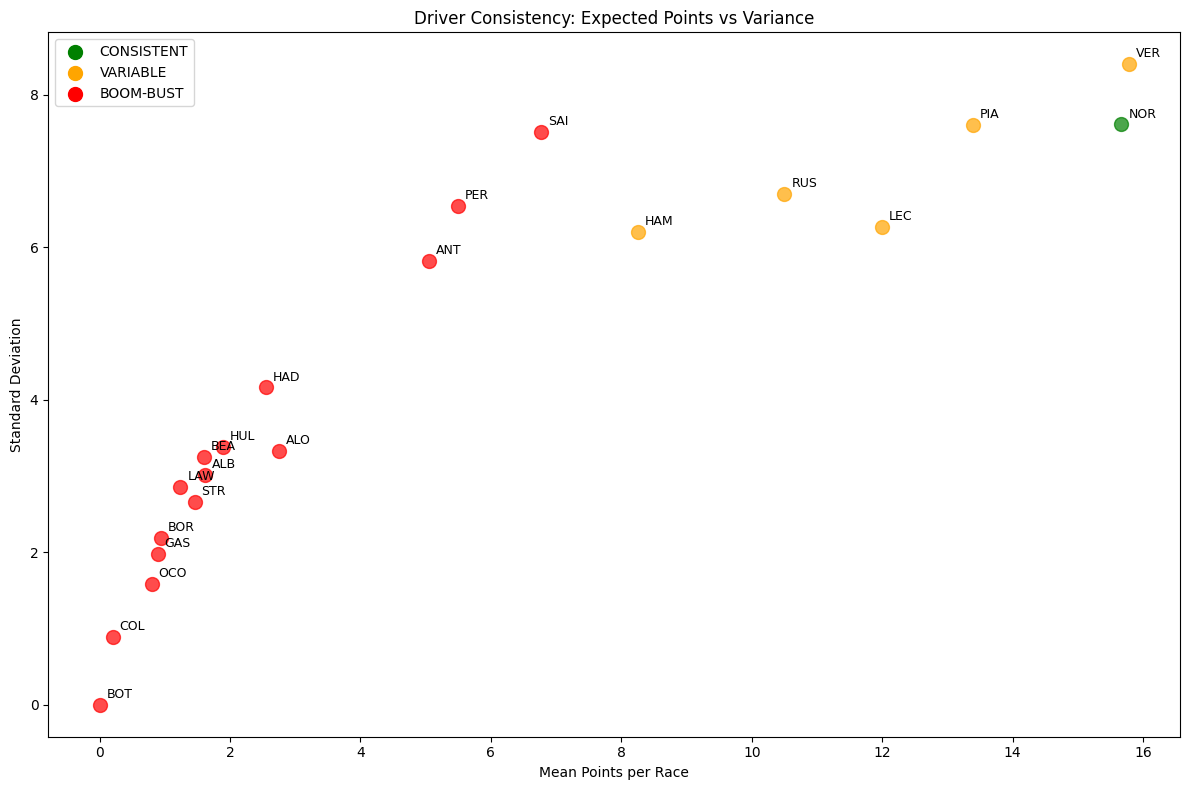

In [18]:
# Cell 5.2: Visualize consistency vs expected points

plt.figure(figsize=(12, 8))

# Filter to 2026 drivers with data
plot_data = consistency[consistency['driver'].isin(DRIVERS_2026.keys())].copy()

# Color by consistency class
colors = {
    'CONSISTENT': 'green',
    'VARIABLE': 'orange', 
    'BOOM-BUST': 'red'
}

for _, row in plot_data.iterrows():
    plt.scatter(row['mean_pts'], row['std_pts'], 
                c=colors[row['consistency']], s=100, alpha=0.7)
    plt.annotate(row['driver'], (row['mean_pts'], row['std_pts']), 
                 xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Mean Points per Race')
plt.ylabel('Standard Deviation')
plt.title('Driver Consistency: Expected Points vs Variance')

# Add legend
for label, color in colors.items():
    plt.scatter([], [], c=color, label=label, s=100)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [19]:
# Cell 5.3: Risk-adjusted recommendations

def get_risk_adjusted_picks(allocation: pd.DataFrame, consistency: pd.DataFrame,
                            season_position: str = 'early') -> list:
    """Adjust picks based on risk tolerance.
    
    Args:
        allocation: Current pick allocation
        consistency: Driver consistency data
        season_position: 'early' (prefer consistent), 'late_ahead' (prefer consistent),
                        'late_behind' (prefer high variance for upside)
    """
    
    consistency_map = dict(zip(consistency['driver'], consistency['consistency']))
    
    suggestions = []
    
    for _, pick in allocation.iterrows():
        driver = pick['driver']
        driver_consistency = consistency_map.get(driver, 'UNKNOWN')
        
        if season_position in ['early', 'late_ahead']:
            # Prefer consistent drivers
            if driver_consistency == 'BOOM-BUST':
                suggestions.append({
                    'round': pick['round'],
                    'race': pick['race'],
                    'driver': driver,
                    'issue': 'High variance driver',
                    'recommendation': 'Consider swapping for a more consistent option'
                })
        elif season_position == 'late_behind':
            # Prefer high-variance drivers for upside
            if driver_consistency == 'CONSISTENT':
                suggestions.append({
                    'round': pick['round'],
                    'race': pick['race'],
                    'driver': driver,
                    'issue': 'Low variance driver',
                    'recommendation': 'If trailing in picks game, consider higher-variance option'
                })
    
    return suggestions

# Early season recommendation
risk_suggestions = get_risk_adjusted_picks(optimal_allocation, consistency, 'early')

print("\nRISK-ADJUSTED RECOMMENDATIONS (Early Season Strategy):")
print("-" * 60)
if risk_suggestions:
    for s in risk_suggestions:
        print(f"R{s['round']:2d} {s['race']:<25} | {s['driver']}: {s['issue']}")
        print(f"    -> {s['recommendation']}")
else:
    print("No adjustments needed - allocation already favors appropriate risk levels.")


RISK-ADJUSTED RECOMMENDATIONS (Early Season Strategy):
------------------------------------------------------------
R 1 Australian Grand Prix     | STR: High variance driver
    -> Consider swapping for a more consistent option
R 4 Bahrain Grand Prix        | PER: High variance driver
    -> Consider swapping for a more consistent option
R 6 Miami Grand Prix          | ALO: High variance driver
    -> Consider swapping for a more consistent option
R 7 Canadian Grand Prix       | ANT: High variance driver
    -> Consider swapping for a more consistent option
R 9 Barcelona Grand Prix      | GAS: High variance driver
    -> Consider swapping for a more consistent option
R11 British Grand Prix        | HUL: High variance driver
    -> Consider swapping for a more consistent option
R13 Hungarian Grand Prix      | BOR: High variance driver
    -> Consider swapping for a more consistent option
R14 Dutch Grand Prix          | HAD: High variance driver
    -> Consider swapping for a more consi

---
## Summary: Final Season Plan

In [20]:
# Cell 6.1: Export final plan

def create_season_summary(allocation: pd.DataFrame, consistency: pd.DataFrame) -> pd.DataFrame:
    """Create comprehensive season summary with all factors."""
    
    consistency_map = dict(zip(consistency['driver'], consistency['consistency']))
    cv_map = dict(zip(consistency['driver'], consistency['cv']))
    
    summary = allocation.copy()
    summary['consistency'] = summary['driver'].map(consistency_map).fillna('UNKNOWN')
    summary['risk_cv'] = summary['driver'].map(cv_map).fillna(1.0)
    
    return summary

season_summary = create_season_summary(optimal_allocation, consistency)

print("=" * 80)
print("2026 F1 PICKS - OPTIMAL SEASON PLAN")
print("=" * 80)
print(f"Total Expected Points: {season_summary['expected_points'].sum():.1f}")
print(f"Average per Race: {season_summary['expected_points'].mean():.2f}")
print("=" * 80)
print()

# Display formatted table
display_cols = ['round', 'race', 'driver', 'driver_name', 'team', 'expected_points', 'consistency']
print(season_summary[display_cols].to_string(index=False))

2026 F1 PICKS - OPTIMAL SEASON PLAN
Total Expected Points: 306.0
Average per Race: 12.75

 round                     race driver       driver_name            team  expected_points consistency
     1    Australian Grand Prix    STR      Lance Stroll    Aston Martin         8.000000   BOOM-BUST
     2       Chinese Grand Prix    LEC   Charles Leclerc         Ferrari        15.315789    VARIABLE
     3      Japanese Grand Prix    VER    Max Verstappen Red Bull Racing        25.384615    VARIABLE
     4       Bahrain Grand Prix    PER      Sergio Perez        Cadillac        18.000000   BOOM-BUST
     5 Saudi Arabian Grand Prix    PIA     Oscar Piastri         McLaren        20.000000    VARIABLE
     6         Miami Grand Prix    ALO   Fernando Alonso    Aston Martin         3.626316   BOOM-BUST
     7      Canadian Grand Prix    ANT    Kimi Antonelli        Mercedes        19.500000   BOOM-BUST
     8        Monaco Grand Prix    LIN    Arvid Lindblad    Racing Bulls         1.800000     

In [21]:
# Cell 6.2: Driver usage summary

driver_usage = season_summary.groupby('driver').agg({
    'round': 'count',
    'expected_points': 'sum',
    'driver_name': 'first',
    'team': 'first'
}).rename(columns={'round': 'races_assigned'})

driver_usage = driver_usage.sort_values('expected_points', ascending=False)

print("\nDRIVER USAGE SUMMARY:")
print("-" * 60)
print(driver_usage.to_string())

# Unused drivers
used_drivers = set(season_summary['driver'].values)
unused_drivers = set(DRIVERS_2026.keys()) - used_drivers

print(f"\nUnused drivers ({len(unused_drivers)}): {', '.join(sorted(unused_drivers))}")


DRIVER USAGE SUMMARY:
------------------------------------------------------------
        races_assigned  expected_points        driver_name             team
driver                                                                     
NOR                  3        56.417004       Lando Norris          McLaren
RUS                  1        26.000000     George Russell         Mercedes
VER                  1        25.384615     Max Verstappen  Red Bull Racing
HAM                  1        25.000000     Lewis Hamilton          Ferrari
PIA                  1        20.000000      Oscar Piastri          McLaren
ANT                  1        19.500000     Kimi Antonelli         Mercedes
HAD                  1        19.500000       Isack Hadjar  Red Bull Racing
PER                  1        18.000000       Sergio Perez         Cadillac
HUL                  1        16.000000    Nico Hulkenberg             Audi
LEC                  1        15.315789    Charles Leclerc          Ferrari
BEA 

In [22]:
# Cell 6.3: Save plan to CSV

output_file = 'optimal_picks_2026.csv'
season_summary.to_csv(output_file, index=False)
print(f"Saved plan to: {output_file}")

Saved plan to: optimal_picks_2026.csv


---
## Phase 6: ML Decision Point

Evaluate whether ML would add value over the simple averaging approach.

In [23]:
# Cell 7.1: Evaluate prediction accuracy of simple model

def evaluate_simple_model(df: pd.DataFrame) -> dict:
    """Evaluate how well historical averages predict race results."""
    
    # Use most recent complete season to predict current/next season
    # Priority: 2025 -> 2026, fallback to 2024 -> 2025
    if len(df[df['year'] == 2026]) > 0:
        train = df[df['year'] == 2025]
        test = df[df['year'] == 2026]
        eval_label = "2025 -> 2026"
    else:
        train = df[df['year'] == 2024]
        test = df[df['year'] == 2025]
        eval_label = "2024 -> 2025"
    
    if len(test) == 0:
        return {'error': 'No test data available', 'label': eval_label}
    
    # Calculate driver-circuit averages from training data
    train_avg = train.groupby(['driver', 'circuit'])['points'].mean().reset_index()
    train_avg.columns = ['driver', 'circuit', 'predicted']
    
    # Merge with test data
    test_with_pred = test.merge(train_avg, on=['driver', 'circuit'], how='left')
    
    # Fill missing with driver average
    driver_avg = train.groupby('driver')['points'].mean()
    test_with_pred['predicted'] = test_with_pred.apply(
        lambda row: row['predicted'] if pd.notna(row['predicted']) 
        else driver_avg.get(row['driver'], 5.0), axis=1
    )
    
    # Calculate metrics
    valid = test_with_pred.dropna(subset=['predicted', 'points'])
    
    if len(valid) == 0:
        return {'error': 'No valid predictions', 'label': eval_label}
    
    mae = np.abs(valid['points'] - valid['predicted']).mean()
    rmse = np.sqrt(((valid['points'] - valid['predicted']) ** 2).mean())
    
    # R-squared
    ss_res = ((valid['points'] - valid['predicted']) ** 2).sum()
    ss_tot = ((valid['points'] - valid['points'].mean()) ** 2).sum()
    r2 = 1 - (ss_res / ss_tot)
    
    return {
        'n_predictions': len(valid),
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'label': eval_label
    }

model_eval = evaluate_simple_model(df_results)

print(f"SIMPLE MODEL EVALUATION ({model_eval.get('label', 'N/A')}):")
print("-" * 40)
print(f"Predictions: {model_eval.get('n_predictions', 'N/A')}")
print(f"MAE: {model_eval.get('mae', 'N/A'):.2f} points")
print(f"RMSE: {model_eval.get('rmse', 'N/A'):.2f} points")
print(f"R²: {model_eval.get('r2', 'N/A'):.3f}")

print("\nML RECOMMENDATION:")
r2 = model_eval.get('r2', 0)
if r2 > 0.5:
    print("  Simple model explains >50% of variance.")
    print("  -> ML unlikely to provide major improvements.")
    print("  -> Stick with historical averaging + form adjustments.")
elif r2 > 0.3:
    print("  Simple model explains 30-50% of variance.")
    print("  -> ML might help with track-specific patterns.")
    print("  -> Consider gradient boosting if time permits.")
else:
    print("  Simple model explains <30% of variance.")
    print("  -> High noise in data - ML may not help significantly.")
    print("  -> Focus on form momentum and qualitative factors.")

SIMPLE MODEL EVALUATION (2024 -> 2025):
----------------------------------------
Predictions: 359
MAE: 4.54 points
RMSE: 6.85 points
R²: 0.090

ML RECOMMENDATION:
  Simple model explains <30% of variance.
  -> High noise in data - ML may not help significantly.
  -> Focus on form momentum and qualitative factors.


---
## Quick Reference Sheet

Printable summary for race-by-race picks.

In [ ]:
# Cell 8.1: Quick Reference Output
# Printable summary with per-race pick recommendations

def print_quick_reference(allocation: pd.DataFrame, close_calls: list, consistency: pd.DataFrame):
    """Print a simple, copy-paste friendly quick reference sheet."""
    
    consistency_map = dict(zip(consistency['driver'], consistency['consistency']))
    close_calls_map = {cc['round']: cc['alternatives'] for cc in close_calls}
    
    print("=" * 65)
    print("  2026 F1 PICKS - QUICK REFERENCE SHEET")
    print("=" * 65)
    print()
    
    for _, row in allocation.iterrows():
        round_num = row['round']
        race_name = row['race'].replace(' Grand Prix', '')
        driver = row['driver']
        driver_name = row['driver_name'].split()[-1]  # Last name only
        exp_pts = row['expected_points']
        cons = consistency_map.get(driver, 'UNKNOWN')
        
        # Format race date from calendar
        race_info = next((r for r in race_calendar if r['round'] == round_num), None)
        date_str = race_info['date'][5:10].replace('-', '/') if race_info else ''  # MM/DD
        
        # Status indicators
        status_icon = ''
        if row['status'] == 'COMPLETED':
            status_icon = '✓ '
        elif row['is_wildcard']:
            status_icon = '★ '
        elif row['is_sprint']:
            status_icon = 'S '
        else:
            status_icon = '  '
        
        # Main line
        print(f"ROUND {round_num:2d} - {race_name} ({date_str})")
        print(f"  {status_icon}→ Pick: {driver} ({driver_name}) | {exp_pts:.1f} pts expected | {cons}")
        
        # Alternatives from close calls
        alts = close_calls_map.get(round_num, [])
        if alts and row['status'] != 'COMPLETED':
            alt_strs = [f"{a['driver']} ({a['points']:.1f})" for a in alts[:3]]
            print(f"     Alternatives: {', '.join(alt_strs)}")
        
        print()
    
    # Summary
    total_pts = allocation['expected_points'].sum()
    print("-" * 65)
    print(f"  TOTAL EXPECTED: {total_pts:.1f} points")
    print(f"  Legend: ✓=Completed, ★=Wild Card, S=Sprint Weekend")
    print("=" * 65)

print_quick_reference(optimal_allocation, close_calls, consistency)